In [ ]:
# --- Célula 1: Imports e Configurações ---
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import gc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
import xgboost

# sklearn: pré-processamento, imputação, pipeline, modelos, redução, clusterização, métricas
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score, classification_report, confusion_matrix, accuracy_score

# extras usados em algumas células (mantê-los no topo evita duplicação)
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer

cols_dict = {
    'track_id': 'Track ID', 'artists': 'Artists', 'album_name': 'Album Name',
    'track_name': 'Track Name', 'popularity': 'Popularity', 'duration_ms': 'Duration (ms)',
    'explicit': 'Explicit', 'danceability': 'Danceability', 'energy': 'Energy',
    'key': 'Key', 'loudness': 'Loudness', 'mode': 'Mode', 'speechiness': 'Speechiness',
    'acousticness': 'Acousticness', 'instrumentalness': 'Instrumentalness',
    'liveness': 'Liveness', 'valence': 'Valence', 'tempo': 'Tempo',
    'time_signature': 'Time Signature', 'track_genre': 'Track Genre'
}

c:\Users\Gabriel Augusto\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# --- Célula 2: Carregamento dos Dados ---
path = kagglehub.dataset_download("maharshipandya/-spotify-tracks-dataset")
df = pd.read_csv(path + '/dataset.csv', index_col=0)
# Remova colunas duplicadas
df = df.loc[:, ~df.columns.duplicated()]
if 'track_genre' not in df.columns:
    df['track_genre'] = 'unknown'

num_features = [
    'popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature'
]

# Remova qualquer coluna extra
df = df[num_features + ['track_genre']].copy()


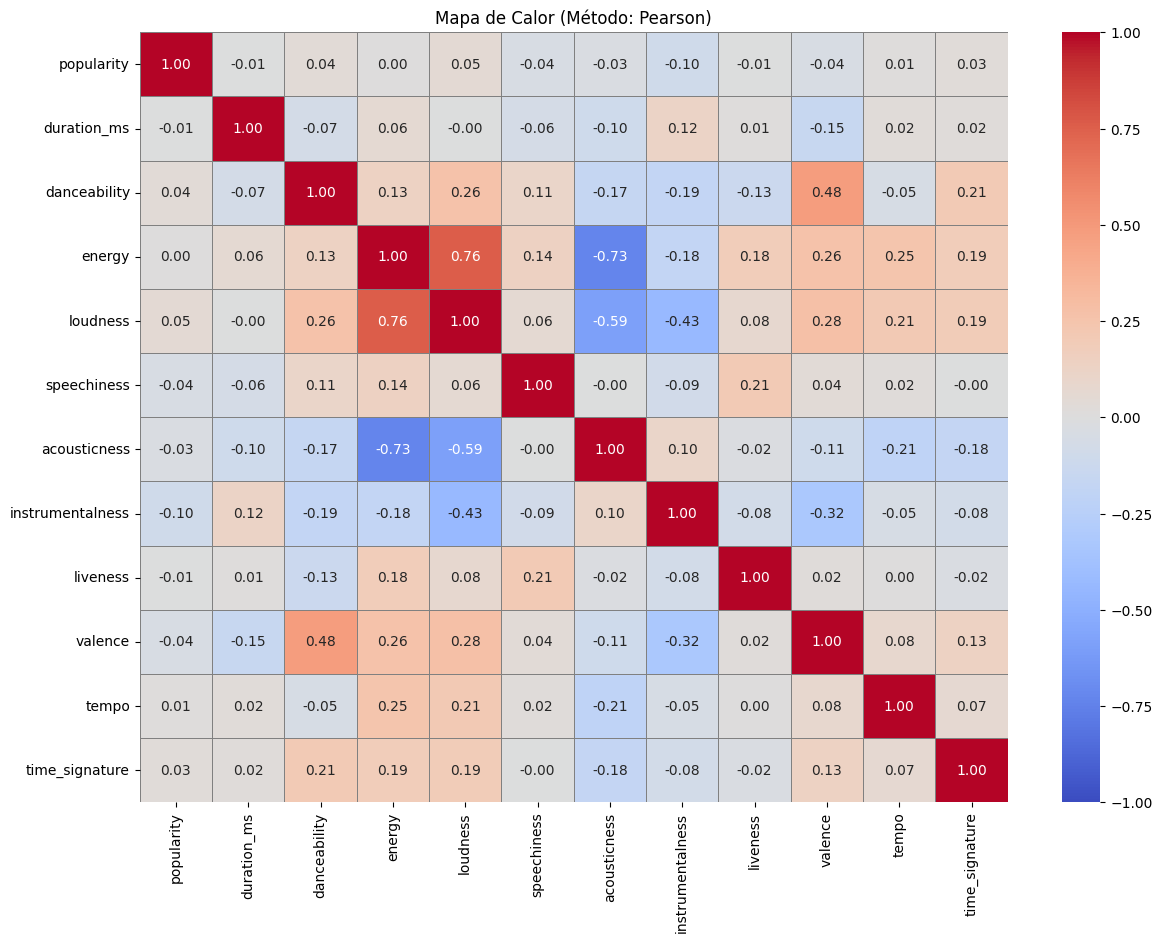

energy        loudness            0.761690
              acousticness       -0.733906
loudness      acousticness       -0.589803
danceability  valence             0.477341
loudness      instrumentalness   -0.433477
dtype: float64

In [25]:
# --- Célula 8: Correlação ---
corr_method = "pearson"
corr_matrix = df[num_features].corr(method=corr_method)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, linewidths=0.5, linecolor='gray')
plt.title(f"Mapa de Calor (Método: {corr_method.capitalize()})")
plt.show()

# Pares com maior correlação
mask_table = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
corr_unstacked = corr_matrix.where(mask_table).stack()
strong_pairs = corr_unstacked[abs(corr_unstacked) > 0.4].sort_values(key=abs, ascending=False)
display(strong_pairs)

Detectados 5700 outliers (contaminação ≈ 0.05).


track_genre  danceability  energy  loudness  acousticness  valence  \
116        acoustic        0.5650  0.0392   -28.276         0.835   0.6010   
163        acoustic        0.7390  0.2870   -14.007         0.969   0.5570   
173        acoustic        0.7690  0.1350   -12.049         0.986   0.4710   
284        acoustic        0.7340  0.0423   -24.831         0.916   0.1400   
324        acoustic        0.3860  0.4280    -9.949         0.951   0.7300   
...             ...           ...     ...       ...           ...      ...   
113972  world-music        0.1700  0.0520   -28.693         0.875   0.0475   
113977  world-music        0.0672  0.0903   -23.496         0.970   0.0361   
113979  world-music        0.4170  0.9670   -27.146         0.924   0.0147   
113995  world-music        0.1720  0.2350   -16.393         0.640   0.0339   
113996  world-music        0.1740  0.1170   -18.318         0.994   0.0350   

        instrumentalness  
116                0.183  
163                0.961  
173                0.905  
284                0.000  
324                0.882  
...                  ...  
113972             0.904  
113977             0.977  
113979             0.958  
113995             0.928  
113996             0.976  

[5700 rows x 7 columns]

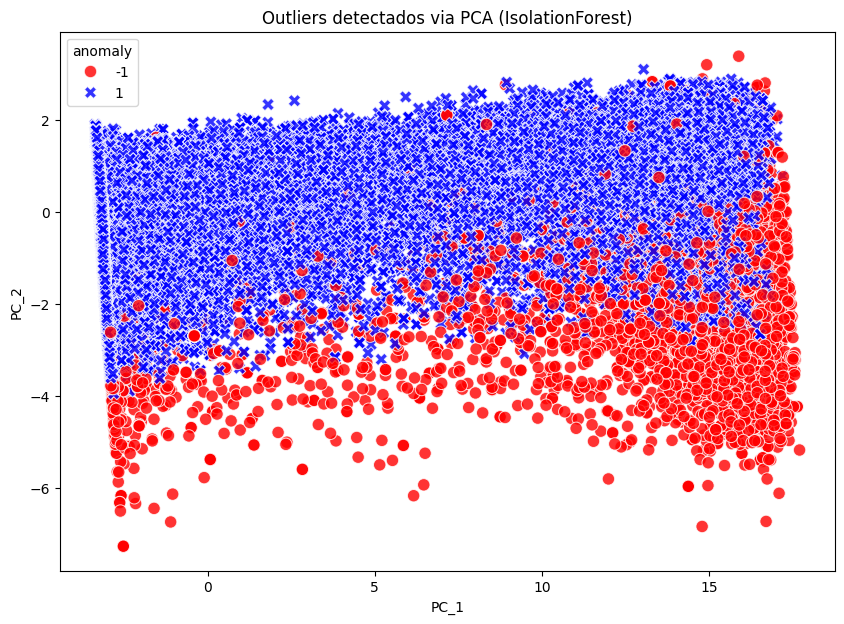

Após remoção de outliers: 108300 linhas.


In [ ]:
# --- Célula 9: Detecção de Outliers com Isolation Forest (corrigida) ---

# Features candidatas (verificar existência)
features_for_outliers = ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'instrumentalness']
feats = [c for c in features_for_outliers if c in df.columns]
if not feats:
    raise ValueError("Nenhuma das features para detecção de outliers está presente no dataframe.")

# Seleciona apenas numéricas e imputa mediana para evitar NaNs durante o escalonamento/modelo
X = df[feats].select_dtypes(include=np.number).copy()
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Escalonamento robusto (menos sensível a outliers extremos)
scaler_out = RobustScaler()
X_scaled = scaler_out.fit_transform(X_imputed.astype(float))

# IsolationForest com contaminação parametrizável (ajustar conforme exploração)
contamination = 0.05
iso = IsolationForest(contamination=contamination, random_state=42)
preds = iso.fit_predict(X_scaled)  # 1 = inlier, -1 = outlier

# Mapear resultados de volta ao dataframe original via índice limpo
df.loc[X_imputed.index, 'anomaly'] = preds

outliers = df.loc[X_imputed.index][df.loc[X_imputed.index, 'anomaly'] == -1]
print(f"Detectados {len(outliers)} outliers (contaminação ≈ {contamination}).")
display(outliers[['track_genre'] + feats])

# Visualização PCA 2D (nomes consistentes: PC_1, PC_2)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC_1', 'PC_2'], index=X_imputed.index)
df_pca['anomaly'] = preds

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='anomaly', palette={1: 'blue', -1: 'red'}, style='anomaly', s=80, alpha=0.8)
plt.title("Outliers detectados via PCA (IsolationForest)")
plt.show()

# Remoção segura de outliers para uso posterior (preserva índices)
df_no_outliers = df.loc[X_imputed.index][df_pca['anomaly'] != -1].copy()
print(f"Após remoção de outliers: {len(df_no_outliers)} linhas.")

# Agrupar gêneros pouco frequentes — usar top_n para consistência com a célula de classificação
top_n = 10
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

In [ ]:
# --- Célula 10: Pré-processamento dos Dados (corrigida — pipeline consistente) ---

# Cria pipeline reprodutível: imputação mediana -> RobustScaler (resistente a outliers) -> MinMax (opcional para modelos que exigem [0,1])
preproc_pipeline = make_pipeline(SimpleImputer(strategy='median'), RobustScaler(), MinMaxScaler())

# Copia segura do dataframe sem outliers
df_processed = df_no_outliers.copy()

# Assegura que num_features existam em df_processed
num_features = [f for f in num_features if f in df_processed.columns]
if not num_features:
    raise ValueError("num_features não encontrados em df_processed.")

# Aplica pipeline (retorna numpy) e reconstrói as colunas
df_processed[num_features] = preproc_pipeline.fit_transform(df_processed[num_features])

# Salva objetos para uso posterior (PCA / inversão / export)
scaler_pipeline = preproc_pipeline

display(df_processed.head())

popularity  duration_ms  danceability    energy  loudness  speechiness  \
0        0.73     0.044043      0.686294  0.460989  0.721409     0.148187   
1        0.55     0.028566      0.426396  0.165983  0.407873     0.079067   
2        0.57     0.040255      0.444670  0.358987  0.632092     0.057720   
3        0.71     0.038557      0.270051  0.059581  0.369612     0.037617   
4        0.82     0.037969      0.627411  0.442989  0.633676     0.054508   

   acousticness  instrumentalness  liveness   valence     tempo  \
0      0.032329          0.000001  0.352006  0.718593  0.394946   
1      0.927711          0.000006  0.092607  0.268342  0.348101   
2      0.210843          0.000000  0.108756  0.120603  0.342903   
3      0.908635          0.000071  0.123896  0.143719  0.816424   
4      0.470884          0.000000  0.074338  0.167839  0.538842   

   time_signature track_genre  anomaly track_genre_grouped  
0             0.8    acoustic      1.0            acoustic  
1             0.8    acoustic      1.0            acoustic  
2             0.8    acoustic      1.0            acoustic  
3             0.6    acoustic      1.0            acoustic  
4             0.8    acoustic      1.0            acoustic

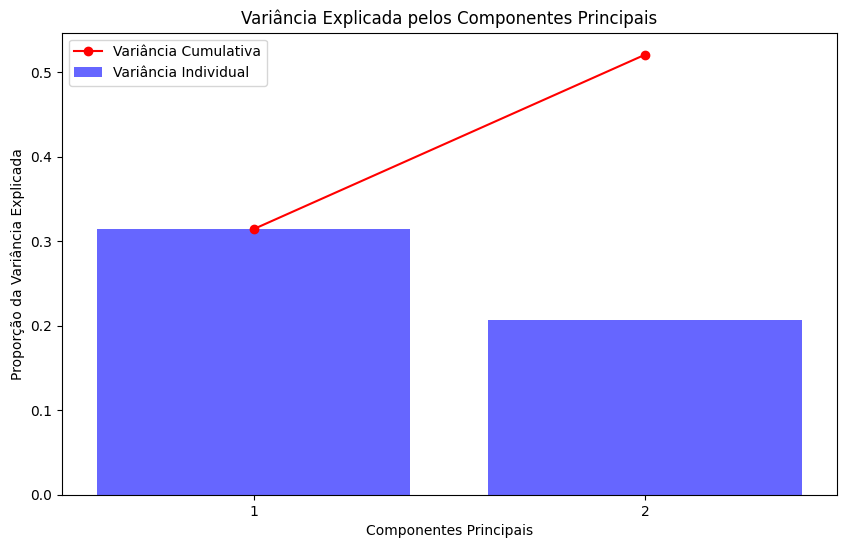

PC_1      PC_2
0 -0.145840 -0.231862
1  0.893308 -0.041666
2  0.199209  0.162731
3  0.943400  0.070574
4  0.323971  0.045757

In [28]:
# --- Célula 11: Redução de Dimensionalidade (PCA) (sem outliers) ---
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_processed[num_features])
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.6, color='b', label='Variância Individual')
plt.plot(range(1, n_components + 1), cumulative_variance, 'r-o', label='Variância Cumulativa')
plt.xlabel('Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Variância Explicada pelos Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components + 1))
plt.show()

df_pca = pd.DataFrame(X_pca, columns=[f'PC_{i+1}' for i in range(n_components)], index=df_processed.index)
display(df_pca.head())


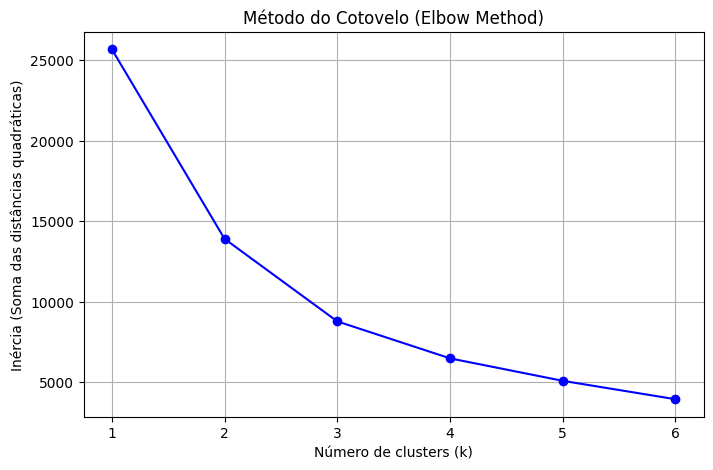

In [29]:
# --- Célula: Elbow Method para determinar o melhor número de clusters ---



# Use o DataFrame df_pca já criado após o PCA (sem a coluna 'cluster', se existir)
X_elbow = df_pca.drop(columns=['cluster'], errors='ignore')

inertias = []
k_range = range(1, 7)  # Testa de 1 a 6 clusters

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_elbow)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'o-', color='blue')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Soma das distâncias quadráticas)')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

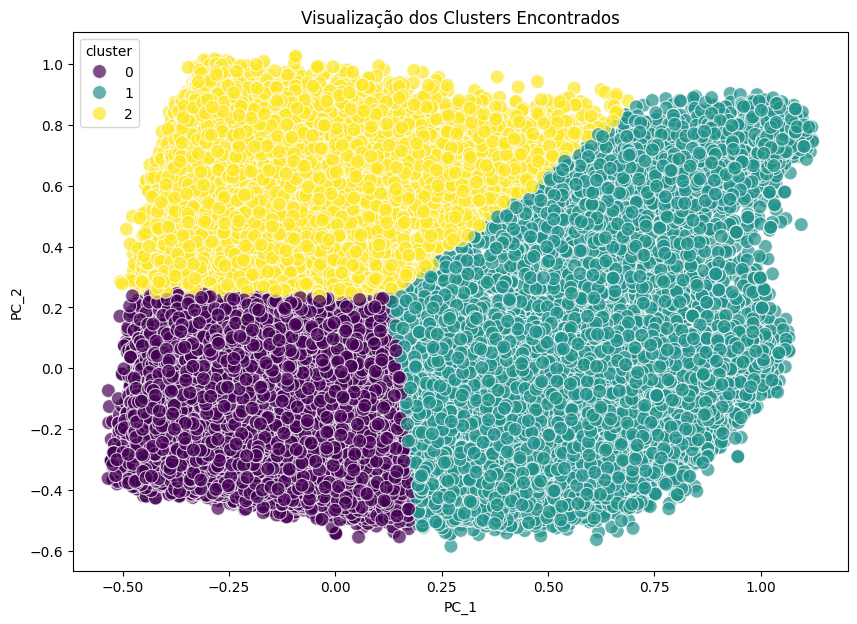

In [30]:
# --- Célula 12: Clusterização ---
k = 3
model = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = model.fit_predict(df_pca)
df_pca['cluster'] = labels

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC_1', y='PC_2', hue='cluster', palette='viridis', s=100, alpha=0.7)
plt.title("Visualização dos Clusters Encontrados")
plt.show()

Silhouette Score: 0.483
Davies-Bouldin Score: 0.711


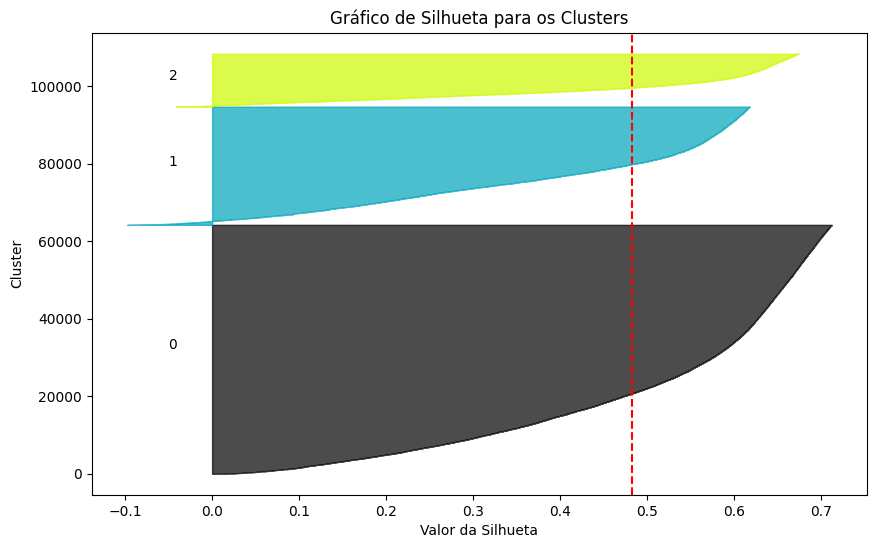

In [10]:
# --- Célula 13: Avaliação dos Clusters KMEANS ---
silhouette_avg = silhouette_score(df_pca.iloc[:, :-1], labels)
davies_bouldin = davies_bouldin_score(df_pca.iloc[:, :-1], labels)
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Calcula os valores de silhueta para cada ponto
silhouette_vals = silhouette_samples(df_pca.iloc[:, :-1], labels)

plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(k):
    ith_cluster_silhouette_values = silhouette_vals[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / k)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper

plt.xlabel("Valor da Silhueta")
plt.ylabel("Cluster")
plt.title("Gráfico de Silhueta para os Clusters")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

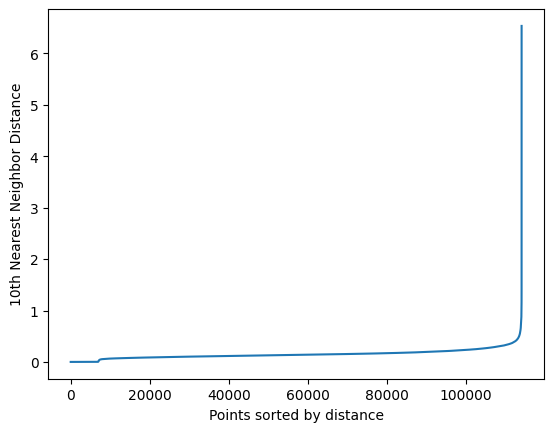

In [15]:
#Definir melhor eps(parametro) para dbscan
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances[:, 9])  # 9 porque n_neighbors=10
plt.plot(distances)
plt.ylabel('10th Nearest Neighbor Distance')
plt.xlabel('Points sorted by distance')
plt.show()

In [ ]:
# --- Célula: Comparação Individual dos Algoritmos de Clusterização (com amostragem para os mais lentos) ---
from sklearn.mixture import GaussianMixture
resultados = []

X = df_pca.iloc[:, :-1]  # já definido anteriormente

# KMeans (rápido)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
sil_kmeans = silhouette_score(X, kmeans_labels)
resultados.append({"Algoritmo": "KMeans", "Clusters": len(set(kmeans_labels)), "Silhouette": sil_kmeans})

# MeanShift (lento)
X_ms = X.sample(n=5000, random_state=42) if len(X) > 5000 else X
ms = MeanShift()
ms_labels = ms.fit_predict(X_ms)
n_clusters_ms = len(set(ms_labels))
sil_ms = silhouette_score(X_ms, ms_labels) if n_clusters_ms > 1 else np.nan
resultados.append({"Algoritmo": "MeanShift", "Clusters": n_clusters_ms, "Silhouette": sil_ms})

# DBSCAN (médio)
X_db = X.sample(n=5000, random_state=42) if len(X) > 5000 else X
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_db)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    sil_dbscan = silhouette_score(X_db[mask], dbscan_labels[mask])
else:
    sil_dbscan = np.nan
resultados.append({"Algoritmo": "DBSCAN", "Clusters": n_clusters_dbscan, "Silhouette": sil_dbscan})

# Agglomerative (médio)
X_agg = X.sample(n=3000, random_state=42) if len(X) > 3000 else X
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_agg)
sil_agg = silhouette_score(X_agg, agg_labels)
resultados.append({"Algoritmo": "Agglomerative", "Clusters": len(set(agg_labels)), "Silhouette": sil_agg})

# Spectral Clustering (lento)
X_sc = X.sample(n=1500, random_state=42) if len(X) > 1500 else X
sc = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
sc_labels = sc.fit_predict(X_sc)
sil_sc = silhouette_score(X_sc, sc_labels)
resultados.append({"Algoritmo": "Spectral", "Clusters": len(set(sc_labels)), "Silhouette": sil_sc})

# Gaussian Mixture Model (rápido)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X)
sil_gmm = silhouette_score(X, gmm_labels)
resultados.append({"Algoritmo": "GMM", "Clusters": len(set(gmm_labels)), "Silhouette": sil_gmm})

# Exibir resultados
resultados_df = pd.DataFrame(resultados)
display(resultados_df)

Algoritmo  Clusters  Silhouette
0         KMeans         3    0.482674
1      MeanShift         2    0.451107
2         DBSCAN         1         NaN
3  Agglomerative         3    0.466256
4       Spectral         3    0.385072
5            GMM         3    0.481931

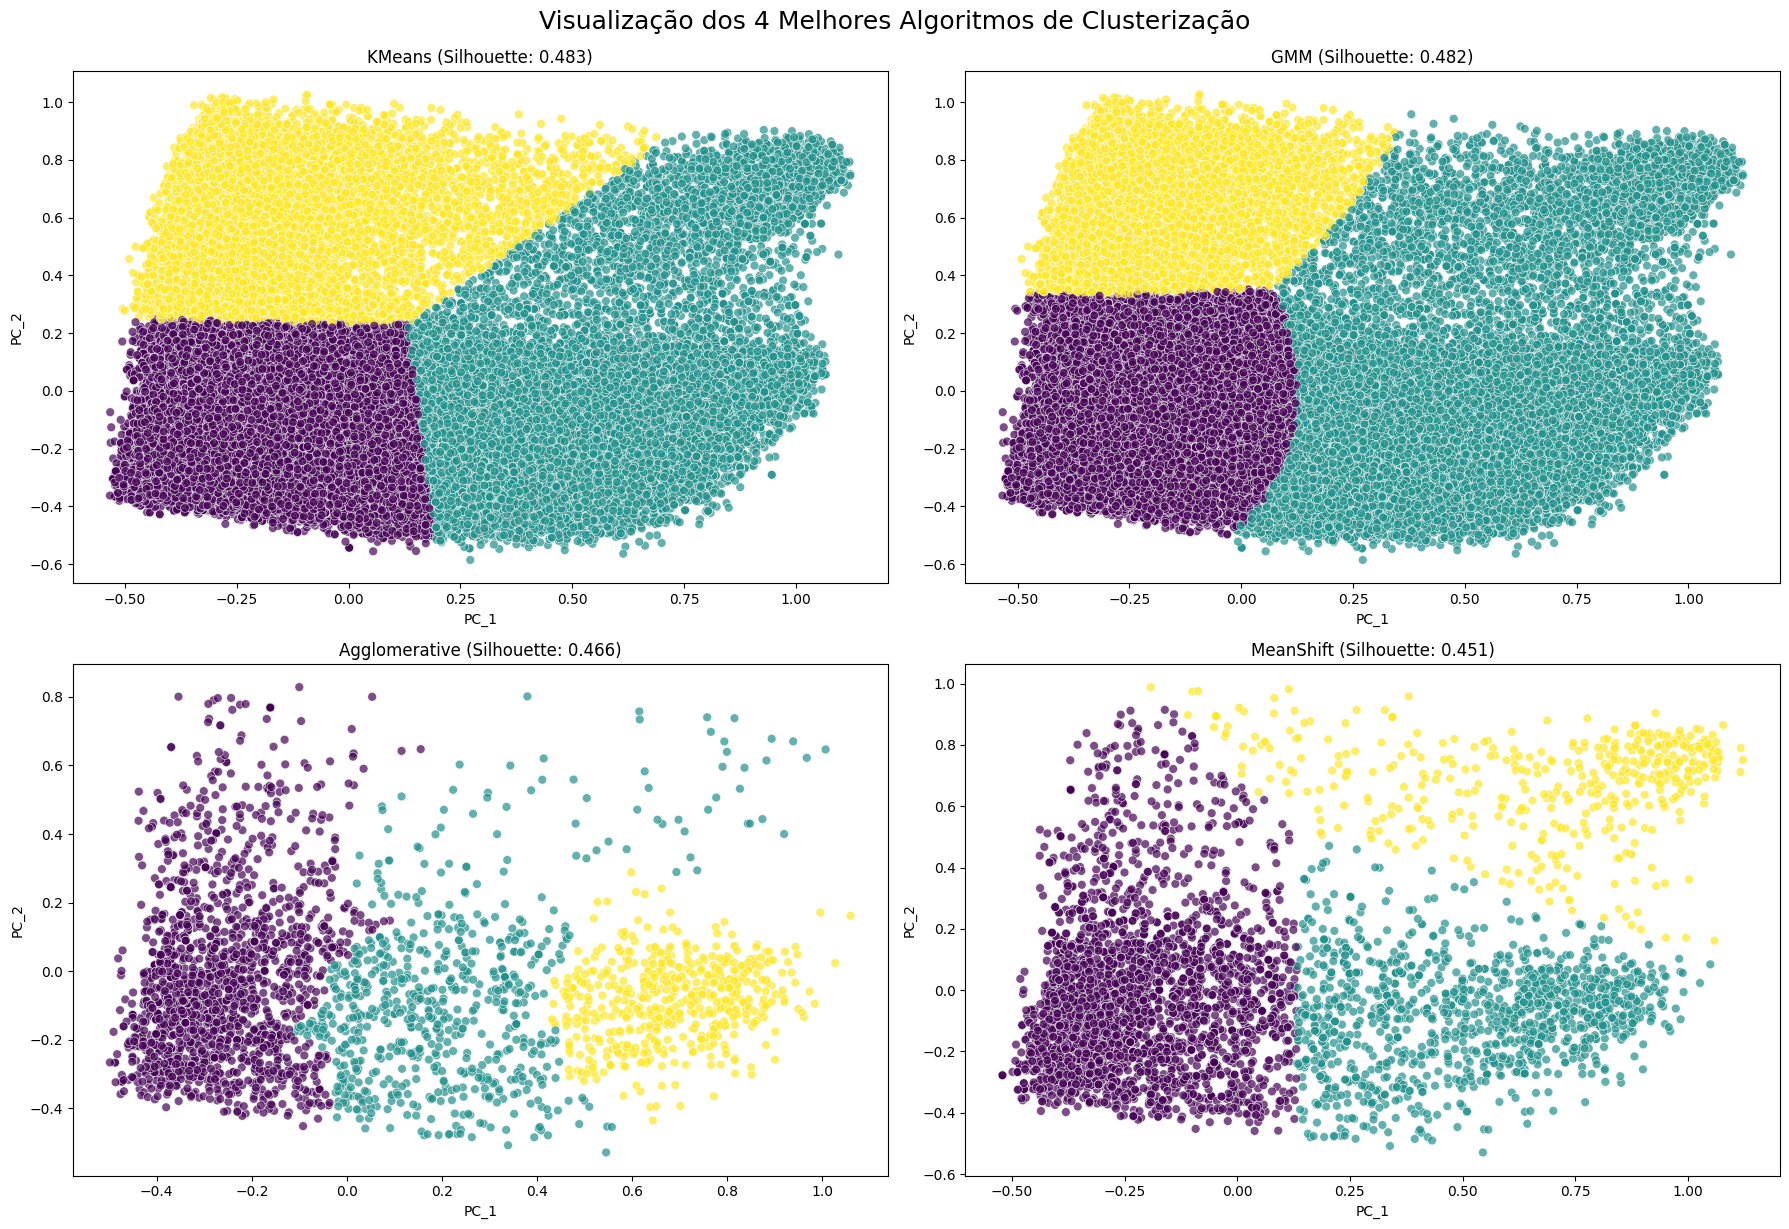

In [18]:
# --- Visualização dos clusters dos 4 melhores algoritmos de clusterização (com os mesmos parâmetros da comparação) ---

# Ordena os resultados pelo Silhouette Score (quanto maior, melhor)
resultados_df_sorted = resultados_df.sort_values(by="Silhouette", ascending=False).reset_index(drop=True)
top4 = resultados_df_sorted.head(4)["Algoritmo"].tolist()

# Dicionário para instanciar novamente os modelos com os mesmos parâmetros usados na comparação
algoritmos = {
    "KMeans": KMeans(n_clusters=3, random_state=42, n_init=10),
    "MeanShift": MeanShift(),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=10),
    "Agglomerative": AgglomerativeClustering(n_clusters=3),
    "Spectral": SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42),
    "GMM": GaussianMixture(n_components=3, random_state=42)
}

# Usa sempre os dois primeiros componentes principais para visualização
X_vis = df_pca.iloc[:, :2].values

plt.figure(figsize=(18, 12))
for i, nome in enumerate(top4):
    plt.subplot(2, 2, i+1)
    modelo = algoritmos[nome]
    # Amostragem igual à da célula de comparação
    if nome == "MeanShift":
        X_plot = X_vis if len(X_vis) <= 5000 else X_vis[:5000]
        labels = modelo.fit_predict(X_plot)
    elif nome == "DBSCAN":
        X_plot = X_vis if len(X_vis) <= 3000 else X_vis[:3000]
        labels = modelo.fit_predict(X_plot)
    elif nome == "Agglomerative":
        X_plot = X_vis if len(X_vis) <= 3000 else X_vis[:3000]
        labels = modelo.fit_predict(X_plot)
    elif nome == "Spectral":
        X_plot = X_vis if len(X_vis) <= 1500 else X_vis[:1500]
        labels = modelo.fit_predict(X_plot)
    else:
        X_plot = X_vis
        labels = modelo.fit_predict(X_plot)
    sns.scatterplot(x=X_plot[:, 0], y=X_plot[:, 1], hue=labels, palette='viridis', s=40, alpha=0.7, legend=False)
    plt.title(f"{nome} (Silhouette: {resultados_df[resultados_df['Algoritmo']==nome]['Silhouette'].values[0]:.3f})")
    plt.xlabel("PC_1")
    plt.ylabel("PC_2")
plt.tight_layout()
plt.suptitle("Visualização dos 4 Melhores Algoritmos de Clusterização", fontsize=18, y=1.02)
plt.show()

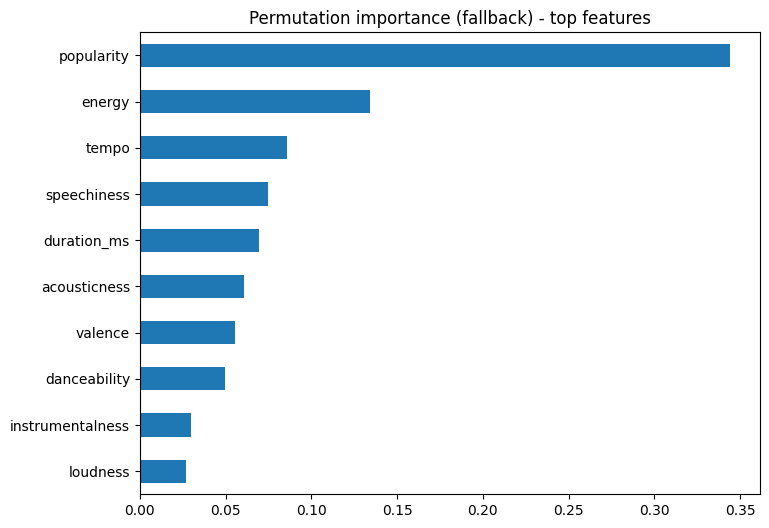

RF feature_importances_ (explainer RF):
popularity          0.275610
energy              0.138053
tempo               0.103338
acousticness        0.084371
duration_ms         0.082575
speechiness         0.081340
valence             0.077267
danceability        0.065787
instrumentalness    0.049796
loudness            0.041863
dtype: float64


11890

In [ ]:
# --- Célula 14 (substituída): SHAP completo — global & local (robusto contra MemoryError) ---
import shap
from sklearn.inspection import permutation_importance

# escolha de features: usa selected_features se existir (criado por RF), senão usa todas num_features
features_for_shap = selected_features if 'selected_features' in globals() and selected_features else num_features

# garante existência de df_no_outliers / df_processed
assert 'df_no_outliers' in globals(), "df_no_outliers não encontrado. Execute a célula de outliers primeiro."
assert 'df_processed' in globals(), "df_processed não encontrado. Execute a célula de pré-processamento primeiro."

# prepara dados (remove classe 'outros' se presente)
if 'track_genre_grouped' not in df_no_outliers.columns:
    top_n = 10
    top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
    df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(df_no_outliers['track_genre'].isin(top_genres), 'outros')

mask = df_no_outliers['track_genre_grouped'] != 'outros'
X_shap_full = df_processed.loc[mask, features_for_shap].copy()
y_shap_full = df_no_outliers.loc[mask, 'track_genre_grouped'].copy()

# label encoder para classes
le_shap = LabelEncoder()
y_shap_enc = le_shap.fit_transform(y_shap_full)
# --- CHANGED: cria Series alinhada ao índice de X_shap_full para indexação segura ---
y_shap_series = pd.Series(y_shap_enc, index=X_shap_full.index)

# amostra para explicar (reduz memória). Ajuste n_explain conforme memória/tempo.
n_explain = min(500, len(X_shap_full))
X_background = X_shap_full.sample(n=min(50, len(X_shap_full)), random_state=42)  # small background
X_explain = X_shap_full.sample(n=n_explain, random_state=42)
# --- CHANGED: usa .loc para selecionar pelos índices do DataFrame -->
y_explain = y_shap_series.loc[X_explain.index].values

# Treina um RF leve para SHAP (explicador) — evita TreeEnsemble gigantes
model_shap = RandomForestClassifier(n_estimators=40, max_depth=8, random_state=42, n_jobs=-1)
# --- CHANGED: garante alinhamento usando os valores da Series ---
model_shap.fit(X_shap_full, y_shap_series.values)

# guard rails: se TreeExplainer falhar por memória, fallback para permutation importance
shap_failed = False
try:
    # TreeExplainer com background reduzido (evita alocar arrays gigantes)
    explainer = shap.TreeExplainer(model_shap, data=X_background, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_explain)  # lista (n_classes) ou array

    # --- Global importance (robusto a formatos multiclass) ---
    def mean_abs_shap(shv):
        a = shv
        if isinstance(a, list):
            arrs = []
            for sv in a:
                sv = np.asarray(sv)
                if sv.ndim == 3:
                    sv = np.mean(np.abs(sv), axis=2)
                arrs.append(np.abs(sv))
            stacked = np.stack(arrs, axis=0)  # (n_classes, n_samples, n_features)
            return stacked.mean(axis=(0,1))
        else:
            sv = np.asarray(a)
            if sv.ndim == 3:
                # (n_samples, n_features, n_outputs) -> collapse last
                if sv.shape[2] == X_explain.shape[1]:
                    sv = np.mean(np.abs(sv), axis=2)
                else:
                    sv = np.abs(sv)
                if sv.ndim == 3:
                    return sv.mean(axis=(0,1))
            if sv.ndim == 2:
                return np.mean(np.abs(sv), axis=0)
            return np.ravel(np.abs(sv))

    mean_abs = mean_abs_shap(shap_values)
    shap_importances = pd.Series(mean_abs, index=features_for_shap).sort_values(ascending=False)

    # Plots globais: bar, beeswarm (summary), per-class summary if multiclass
    shap.initjs()
    plt.figure(figsize=(8,6))
    shap_importances.head(12).plot.barh()
    plt.gca().invert_yaxis()
    plt.title("SHAP mean(|value|) - global (bar)")
    plt.show()

    # beeswarm / summary (works with list for multiclass; pass class_names to annotate)
    plt.figure(figsize=(10,7))
    try:
        # for multiclass shap_values can be list -> shap.summary_plot handles it
        shap.summary_plot(shap_values, X_explain, feature_names=features_for_shap, class_names=le_shap.classes_, show=True)
    except Exception:
        shap.summary_plot(shap_values, X_explain, feature_names=features_for_shap, show=True)

    # Dependence plots para top 3 features
    top_feats = shap_importances.head(3).index.tolist()
    for feat in top_feats:
        plt.figure(figsize=(8,5))
        # use color by another top feature to show interaction
        other = top_feats[1] if len(top_feats) > 1 and top_feats[1] != feat else None
        try:
            shap.dependence_plot(feat, shap_values, X_explain, feature_names=features_for_shap, interaction_index=other)
        except Exception:
            # fallback: use shap_values for first class if list
            vals = shap_values[0] if isinstance(shap_values, list) else shap_values
            shap.dependence_plot(feat, vals, X_explain, feature_names=features_for_shap, interaction_index=other)

except (MemoryError, Exception) as e:
    shap_failed = True
    warnings.warn(f"SHAP TreeExplainer falhou ({type(e).__name__}); fallback para permutation importance.", UserWarning)
    perm = permutation_importance(model_shap, X_shap_full, y_shap_series.values, n_repeats=12, random_state=42, n_jobs=-1, scoring='f1_macro')
    shap_importances = pd.Series(perm.importances_mean, index=features_for_shap).sort_values(ascending=False)

    plt.figure(figsize=(8,6))
    shap_importances.head(12).plot.barh()
    plt.gca().invert_yaxis()
    plt.title("Permutation importance (fallback) - top features")
    plt.show()

# --- Local explanations: force / waterfall / decision plots para exemplos (se SHAP ok) ---
if not shap_failed:
    # escolhe alguns exemplos: 1 correto, 1 incorreto (se houver y_true disponível)
    preds = model_shap.predict(X_explain)
    preds_labels = le_shap.inverse_transform(preds)
    true_labels = le_shap.inverse_transform(y_explain)

    correct_idx = X_explain.index[(preds == y_explain)][:1]
    wrong_idx = X_explain.index[(preds != y_explain)][:1]

    # função utilitária para mostrar explicação local (multiclass-aware)
    def show_local(iidx):
        i = iidx  # index label from DataFrame
        x_row = X_explain.loc[[i]]
        # escolhe classe com maior prob pred para o sample
        probs = model_shap.predict_proba(x_row)[0]
        pred_class = np.argmax(probs)
        exp_val = explainer.expected_value
        sv = shap_values[pred_class] if isinstance(shap_values, list) else shap_values

        # Force plot (interactive)
        true_label = le_shap.inverse_transform([int(y_shap_series.loc[i])])[0] if i in y_shap_series.index else 'N/A'
        print(f"Sample index: {i} | true: {true_label} | predicted: {le_shap.classes_[pred_class]}")
        shap.initjs()
        try:
            display(shap.force_plot(exp_val[pred_class], sv[X_explain.index.get_loc(i)], x_row.iloc[0], matplotlib=False))
        except Exception:
            # fallback to matplotlib waterfall
            try:
                shap.plots.waterfall(shap.Explanation(values=sv[X_explain.index.get_loc(i)], base_values=exp_val[pred_class], data=x_row.iloc[0], feature_names=features_for_shap))
            except Exception:
                print("Não foi possível gerar force/waterfall plot para esse sample.")

        # Decision plot (shows contributions across features cumulatively)
        try:
            shap.decision_plot(exp_val[pred_class], sv[X_explain.index.get_loc(i)], feature_names=features_for_shap, highlight=0)
        except Exception:
            pass

    # mostrar um exemplo correto e um errado (se existirem)
    if len(correct_idx) > 0:
        print("Exemplo correto:")
        show_local(correct_idx[0])
    if len(wrong_idx) > 0:
        print("Exemplo incorreto:")
        show_local(wrong_idx[0])

# imprime importâncias RF como referência e define/atualiza selected_features se ainda não foi definido
rf_imp = pd.Series(model_shap.feature_importances_, index=features_for_shap).sort_values(ascending=False)
print("RF feature_importances_ (explainer RF):")
print(rf_imp.head(12))

if 'selected_features' not in globals():
    selected_features = rf_imp.head(10).index.tolist()
    print("Selected features (top 10) definidas a partir do RF explainer:", selected_features)

# libera memória de objetos pesados
for n in ('explainer','shap_values','X_shap_full','X_explain','X_background'):
    try:
        del globals()[n]
    except Exception:
        pass
gc.collect()

In [20]:
# --- Geração de Tabela de Resultados para Relatório (corrigida e robusta) ---
from sklearn.metrics import classification_report, accuracy_score

def tabela_resultados(y_true_enc, y_pred_enc, le, modelo_nome, dataset_nome="Teste"):
    """
    Gera DataFrame no formato do relatório para um modelo e conjunto (treino ou teste).
    Recebe y_true_enc / y_pred_enc como labels codificados (inteiros) compatíveis com `le`.
    """
    labels = np.arange(len(le.classes_))
    report = classification_report(y_true_enc, y_pred_enc, labels=labels, target_names=le.classes_,
                                   output_dict=True, zero_division=0)
    accuracy = accuracy_score(y_true_enc, y_pred_enc)

    tabela = pd.DataFrame({
        "Métrica": ["Precisão", "Recall", "F1-Score", "Suporte", "Acurácia"],
    })

    # classes
    for cls in le.classes_:
        cls_rep = report.get(cls, {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0})
        tabela[cls] = [
            f"{cls_rep['precision']:.3f}".replace('.', ','),
            f"{cls_rep['recall']:.3f}".replace('.', ','),
            f"{cls_rep['f1-score']:.3f}".replace('.', ','),
            int(round(cls_rep.get('support', 0))),
            "-"  # Acurácia por classe não existe
        ]

    # Médias
    macro = report.get('macro avg', {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0})
    weighted = report.get('weighted avg', {"precision": 0.0, "recall": 0.0, "f1-score": 0.0, "support": 0})

    tabela["Média"] = [
        f"{macro['precision']:.3f}".replace('.', ','),
        f"{macro['recall']:.3f}".replace('.', ','),
        f"{macro['f1-score']:.3f}".replace('.', ','),
        int(round(macro.get('support', 0))),
        f"{accuracy:.3f}".replace('.', ',')
    ]
    tabela["Média Ponderada"] = [
        f"{weighted['precision']:.3f}".replace('.', ','),
        f"{weighted['recall']:.3f}".replace('.', ','),
        f"{weighted['f1-score']:.3f}".replace('.', ','),
        int(round(weighted.get('support', 0))),
        "-"
    ]

    tabela.insert(0, "Modelo", modelo_nome)
    tabela.insert(1, "Conjunto", dataset_nome)
    return tabela

In [ ]:
# ...existing code...
# --- Célula: Classificação segura — SMOTE dentro do pipeline/CV (corrigida: sem Pipeline aninhado) ---
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, make_scorer
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 1) Agrupar gêneros pouco frequentes (top N) — usa df_no_outliers já preparado
top_n = 10
top_genres = df_no_outliers['track_genre'].value_counts().nlargest(top_n).index
df_no_outliers['track_genre_grouped'] = df_no_outliers['track_genre'].where(
    df_no_outliers['track_genre'].isin(top_genres), 'outros'
)

# 2) Features selecionadas (assume selected_features já definido)
X = df_processed[selected_features].copy()
y = df_no_outliers['track_genre_grouped'].copy()

# 3) Remover classe 'outros' para classificação multiclasse limpa (opcional)
mask = y != 'outros'
X = X.loc[mask]
y = y.loc[mask]

# 4) Codificar rótulos
le = LabelEncoder()
y_enc = le.fit_transform(y)

# 5) Split treino/test (aqui apenas divisão; SMOTE será aplicado somente dentro do pipeline no treino)
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# 6) Modelos a testar (mantidos como antes)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "RandomForest": RandomForestClassifier(n_estimators=70, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "XGBClassifier": XGBClassifier(n_estimators=70, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LGBMClassifier": LGBMClassifier(n_estimators=70, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=70, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=70, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=7),
    "SVC": SVC(kernel='rbf', probability=True, random_state=42),
    "NaiveBayes": GaussianNB()
}

results = []

# Scorers
scoring = {
    'macro_f1': make_scorer(f1_score, average='macro'),
    'balanced_acc': make_scorer(balanced_accuracy_score)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, base_model in models.items():
    print("="*60)
    print(f"Modelo: {name}")
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('robust', RobustScaler()),
        ('minmax', MinMaxScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', base_model)
    ])

    # 1) CV seguro: pipeline inclui SMOTE e pré-processamento; executa CV primeiro (evita vazamento)
    cv_scores = cross_validate(pipeline, X, y_enc, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    print(f"\nCV Macro F1 (mean ± std): {cv_scores['test_macro_f1'].mean():.3f} ± {cv_scores['test_macro_f1'].std():.3f}")
    print(f"CV Balanced Acc (mean ± std): {cv_scores['test_balanced_acc'].mean():.3f} ± {cv_scores['test_balanced_acc'].std():.3f}")

    # 2) Treina pipeline no treino completo e avalia no hold-out (X_train/X_test)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Métricas no teste
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Accuracy (teste): {acc:.3f} | Balanced Acc: {bal_acc:.3f} | Macro F1: {macro_f1:.3f}")
    print("\nClassification Report:")
    print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred), digits=3, zero_division=0))

    # Matriz de confusão (labels originais)
    conf_df = pd.DataFrame(
        confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), labels=le.classes_),
        index=le.classes_, columns=le.classes_
    )
    print("\nMatriz de Confusão:")
    display(conf_df)

    results.append({
        'model': name,
        'accuracy_test': acc,
        'balanced_acc_test': bal_acc,
        'macro_f1_test': macro_f1,
        'cv_macro_f1_mean': cv_scores['test_macro_f1'].mean(),
        'cv_macro_f1_std': cv_scores['test_macro_f1'].std()
    })
    print("="*60)

results_df = pd.DataFrame(results).sort_values(by='cv_macro_f1_mean', ascending=False).reset_index(drop=True)
print("\nResumo dos modelos (ordenado por CV Macro F1):")
display(results_df)
# ...existing code...

Modelo: RandomForest

CV Macro F1 (mean ± std): 0.689 ± 0.003
CV Balanced Acc (mean ± std): 0.691 ± 0.003
Accuracy (teste): 0.700 | Balanced Acc: 0.699 | Macro F1: 0.699

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.833     0.775     0.803       200
       dance      0.631     0.565     0.596       200
   dancehall      0.787     0.815     0.801       200
         edm      0.365     0.360     0.363       200
     electro      0.420     0.460     0.439       200
       forro      0.831     0.910     0.869       200
      gospel      0.803     0.815     0.809       200
       happy      0.771     0.775     0.773       200
   hard-rock      0.801     0.805     0.803       200
   hardstyle      0.761     0.715     0.737       200

    accuracy                          0.700      2000
   macro avg      0.700     0.699     0.699      2000
weighted avg      0.700     0.700     0.699      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        155      0          7    0        4      4      23      4   
dance             0    113          9   41       32      0       0      0   
dancehall         0     15        163    5        7      5       0      3   
edm               1     25         12   72       80      4       0      1   
electro           3     18          4   72       92      0       2      0   
forro             4      0          3    1        0    182       6      0   
gospel           15      0          0    0        1     14     163      0   
happy             0      1          2    1        0      0       0    155   
hard-rock         6      6          1    3        2     10       8      2   
hardstyle         2      1          6    2        1      0       1     36   

           hard-rock  hardstyle  
cantopop           1          2  
dance              4          1  
dancehall          1          1  
edm                3          2  
electro            8          1  
forro              4          0  
gospel             7          0  
happy              4         37  
hard-rock        161          1  
hardstyle          8        143

Modelo: LogisticRegression

CV Macro F1 (mean ± std): 0.485 ± 0.014
CV Balanced Acc (mean ± std): 0.499 ± 0.013
Accuracy (teste): 0.508 | Balanced Acc: 0.508 | Macro F1: 0.493

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.621     0.640     0.631       200
       dance      0.389     0.455     0.419       200
   dancehall      0.580     0.635     0.606       200
         edm      0.356     0.285     0.317       200
     electro      0.237     0.095     0.136       200
       forro      0.631     0.760     0.689       200
      gospel      0.546     0.565     0.555       200
       happy      0.551     0.565     0.558       200
   hard-rock      0.487     0.580     0.530       200
   hardstyle      0.476     0.500     0.488       200

    accuracy                          0.508      2000
   macro avg      0.488     0.508     0.493      2000
weighted avg      0.488     0.508     0.493      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        128      5          5    5        8      5      30      2   
dance             7     91         27   20       13     12       6      3   
dancehall         1     27        127   12       10     13       0      1   
edm               0     54         15   57       15      8      12     10   
electro          21     42         23   38       19     15      11      9   
forro             6      3          4    4        8    152       6      1   
gospel           32      1          4    6        3     16     113      1   
happy             0      3          3    4        3      4       1    113   
hard-rock        11      5          4    3        1     10      24     10   
hardstyle         0      3          7   11        0      6       4     55   

           hard-rock  hardstyle  
cantopop          12          0  
dance             13          8  
dancehall          6          3  
edm               17         12  
electro           16          6  
forro             14          2  
gospel            20          4  
happy             10         59  
hard-rock        116         16  
hardstyle         14        100

Modelo: XGBClassifier

CV Macro F1 (mean ± std): 0.697 ± 0.004
CV Balanced Acc (mean ± std): 0.697 ± 0.004
Accuracy (teste): 0.713 | Balanced Acc: 0.713 | Macro F1: 0.714

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.847     0.805     0.826       200
       dance      0.620     0.570     0.594       200
   dancehall      0.817     0.825     0.821       200
         edm      0.373     0.420     0.395       200
     electro      0.437     0.435     0.436       200
       forro      0.843     0.910     0.875       200
      gospel      0.815     0.815     0.815       200
       happy      0.796     0.760     0.777       200
   hard-rock      0.829     0.825     0.827       200
   hardstyle      0.784     0.760     0.772       200

    accuracy                          0.713      2000
   macro avg      0.716     0.713     0.714      2000
weighted avg      0.716     0.713     0.714      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        161      0          2    1        2      5      22      3   
dance             0    114          9   47       27      0       0      0   
dancehall         1     19        165    4        2      5       0      0   
edm               1     23         10   84       77      3       0      0   
electro           1     23          6   76       87      0       1      1   
forro             3      0          1    3        0    182       8      0   
gospel           15      0          0    1        1     13     163      0   
happy             1      0          2    3        0      1       0    152   
hard-rock         5      5          2    4        2      7       6      2   
hardstyle         2      0          5    2        1      0       0     33   

           hard-rock  hardstyle  
cantopop           3          1  
dance              3          0  
dancehall          2          2  
edm                2          0  
electro            5          0  
forro              3          0  
gospel             7          0  
happy              4         37  
hard-rock        165          2  
hardstyle          5        152

Modelo: LGBMClassifier

CV Macro F1 (mean ± std): 0.701 ± 0.005
CV Balanced Acc (mean ± std): 0.702 ± 0.005
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 10
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
Accuracy (teste): 0.712 | Balanced Acc: 0.711 | Macro F1: 0.713


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        159      0          2    0        4      4      21      3   
dance             0    118          7   45       25      0       0      0   
dancehall         1     19        164    2        4      5       1      0   
edm               1     25         10   78       79      4       0      0   
electro           0     25          5   74       89      0       2      0   
forro             2      0          2    2        0    183       5      0   
gospel           14      0          0    1        1     14     165      0   
happy             1      0          1    3        0      1       0    156   
hard-rock         3      5          3    4        3      8       8      2   
hardstyle         2      0          5    3        1      1       2     33   

           hard-rock  hardstyle  
cantopop           5          2  
dance              5          0  
dancehall          1          3  
edm                3          0  
electro            4          1  
forro              6          0  
gospel             5          0  
happy              4         34  
hard-rock        162          2  
hardstyle          4        149

Modelo: GradientBoosting

CV Macro F1 (mean ± std): 0.692 ± 0.002
CV Balanced Acc (mean ± std): 0.693 ± 0.002
Accuracy (teste): 0.695 | Balanced Acc: 0.695 | Macro F1: 0.693

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.814     0.790     0.802       200
       dance      0.529     0.600     0.562       200
   dancehall      0.734     0.785     0.758       200
         edm      0.410     0.435     0.422       200
     electro      0.474     0.365     0.412       200
       forro      0.826     0.880     0.852       200
      gospel      0.811     0.795     0.803       200
       happy      0.805     0.785     0.795       200
   hard-rock      0.739     0.780     0.759       200
   hardstyle      0.793     0.730     0.760       200

    accuracy                          0.695      2000
   macro avg      0.694     0.695     0.693      2000
weighted avg      0.694     0.695     0.693      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        158      0          4    1        5      5      19      4   
dance             0    120          9   42       21      0       0      0   
dancehall         0     20        157    5        5      6       0      1   
edm               1     40         15   87       40      5       0      0   
electro           3     39         10   65       73      1       2      1   
forro             6      0          4    3        0    176       6      0   
gospel           21      0          1    0        1     10     159      0   
happy             0      1          4    0        0      1       0    157   
hard-rock         4      6          1    4        9      9       8      2   
hardstyle         1      1          9    5        0      0       2     30   

           hard-rock  hardstyle  
cantopop           3          1  
dance              6          2  
dancehall          5          1  
edm                9          3  
electro            6          0  
forro              5          0  
gospel             8          0  
happy              7         30  
hard-rock        156          1  
hardstyle          6        146

Modelo: AdaBoost

CV Macro F1 (mean ± std): 0.474 ± 0.025
CV Balanced Acc (mean ± std): 0.473 ± 0.025
Accuracy (teste): 0.482 | Balanced Acc: 0.483 | Macro F1: 0.482

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.703     0.545     0.614       200
       dance      0.335     0.300     0.317       200
   dancehall      0.599     0.560     0.579       200
         edm      0.246     0.565     0.343       200
     electro      0.308     0.160     0.211       200
       forro      0.767     0.690     0.726       200
      gospel      0.649     0.600     0.623       200
       happy      0.553     0.700     0.618       200
   hard-rock      0.431     0.465     0.447       200
   hardstyle      0.585     0.240     0.340       200

    accuracy                          0.482      2000
   macro avg      0.518     0.483     0.482      2000
weighted avg      0.518     0.482     0.482      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        109      0          2   25        1      7      35      4   
dance             0     60         19   85       27      0       1      2   
dancehall         4     19        112   14       19     14       1      4   
edm               3     43          9  113       18      7       1      1   
electro           2     39         16  100       32      1       1      0   
forro            11      0          9   13        0    138       9      0   
gospel           23      0          3   20        0      3     120      0   
happy             0      1          7   12        1      1       0    140   
hard-rock         3     17          2   52        5      7      16      4   
hardstyle         0      0          8   25        1      2       1     98   

           hard-rock  hardstyle  
cantopop          14          3  
dance              4          2  
dancehall         11          2  
edm                5          0  
electro            9          0  
forro             15          5  
gospel            30          1  
happy             18         20  
hard-rock         93          1  
hardstyle         17         48

Modelo: DecisionTree

CV Macro F1 (mean ± std): 0.604 ± 0.008
CV Balanced Acc (mean ± std): 0.603 ± 0.008
Accuracy (teste): 0.592 | Balanced Acc: 0.592 | Macro F1: 0.593

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.694     0.680     0.687       200
       dance      0.514     0.560     0.536       200
   dancehall      0.659     0.600     0.628       200
         edm      0.260     0.280     0.270       200
     electro      0.394     0.400     0.397       200
       forro      0.768     0.795     0.781       200
      gospel      0.732     0.710     0.721       200
       happy      0.630     0.665     0.647       200
   hard-rock      0.680     0.615     0.646       200
   hardstyle      0.632     0.610     0.621       200

    accuracy                          0.592      2000
   macro avg      0.596     0.592     0.593      2000
weighted avg      0.596     0.592     0.593      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        136      1         12    5        1      9      23      6   
dance             1    112         11   49       19      1       0      0   
dancehall         3     24        120    9       12      9       3      6   
edm               3     39          8   56       81      2       1      1   
electro           4     32         10   67       80      1       0      0   
forro             5      0          3    5        1    159      16      1   
gospel           27      0          2    0        0     17     142      0   
happy             3      1          4    4        1      0       1    133   
hard-rock        12      8          6   13        8      9       7      9   
hardstyle         2      1          6    7        0      0       1     55   

           hard-rock  hardstyle  
cantopop           3          4  
dance              5          2  
dancehall         10          4  
edm                6          3  
electro            3          3  
forro             10          0  
gospel            11          1  
happy              4         49  
hard-rock        123          5  
hardstyle          6        122

Modelo: KNeighbors

CV Macro F1 (mean ± std): 0.609 ± 0.007
CV Balanced Acc (mean ± std): 0.612 ± 0.007
Accuracy (teste): 0.619 | Balanced Acc: 0.619 | Macro F1: 0.617

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.657     0.755     0.702       200
       dance      0.512     0.540     0.526       200
   dancehall      0.717     0.710     0.714       200
         edm      0.332     0.390     0.359       200
     electro      0.458     0.350     0.397       200
       forro      0.740     0.855     0.794       200
      gospel      0.739     0.735     0.737       200
       happy      0.722     0.610     0.661       200
   hard-rock      0.718     0.560     0.629       200
   hardstyle      0.628     0.685     0.656       200

    accuracy                          0.619      2000
   macro avg      0.622     0.619     0.617      2000
weighted avg      0.622     0.619     0.617      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        151      0          3    0        3      5      29      2   
dance             4    108         13   45       25      0       0      0   
dancehall         8     21        142   10        5      9       2      2   
edm               8     43         11   78       42      6       0      1   
electro          11     24          9   73       70      3       0      0   
forro             8      0          7    2        0    171       5      1   
gospel           27      0          3    1        2     15     147      1   
happy             0      2          3    2        0      1       0    122   
hard-rock        11     11          2   20        6     16      14      4   
hardstyle         2      2          5    4        0      5       2     36   

           hard-rock  hardstyle  
cantopop           4          3  
dance              5          0  
dancehall          1          0  
edm                5          6  
electro            8          2  
forro              6          0  
gospel             4          0  
happy              4         66  
hard-rock        112          4  
hardstyle          7        137

Modelo: SVC

CV Macro F1 (mean ± std): 0.606 ± 0.007
CV Balanced Acc (mean ± std): 0.610 ± 0.008
Accuracy (teste): 0.627 | Balanced Acc: 0.627 | Macro F1: 0.623

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.773     0.785     0.779       200
       dance      0.475     0.670     0.556       200
   dancehall      0.663     0.650     0.657       200
         edm      0.426     0.445     0.435       200
     electro      0.527     0.295     0.378       200
       forro      0.757     0.870     0.809       200
      gospel      0.776     0.675     0.722       200
       happy      0.682     0.580     0.627       200
   hard-rock      0.654     0.680     0.667       200
   hardstyle      0.574     0.620     0.596       200

    accuracy                          0.627      2000
   macro avg      0.631     0.627     0.623      2000
weighted avg      0.631     0.627     0.623      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        157      0          4    0        4      4      20      1   
dance             0    134          4   30       26      0       0      1   
dancehall         1     34        130   12        4     11       0      1   
edm               3     54         14   89       11      7       2      5   
electro           2     51         10   62       59      1       2      0   
forro             5      0          6    0        0    174       5      1   
gospel           29      0          4    0        2     16     135      1   
happy             1      0          7    4        0      3       0    116   
hard-rock         5      8          5    9        6     10       9      3   
hardstyle         0      1         12    3        0      4       1     41   

           hard-rock  hardstyle  
cantopop           6          4  
dance              4          1  
dancehall          4          3  
edm               13          2  
electro            9          4  
forro              7          2  
gospel             7          6  
happy              8         61  
hard-rock        136          9  
hardstyle         14        124

Modelo: NaiveBayes

CV Macro F1 (mean ± std): 0.521 ± 0.010
CV Balanced Acc (mean ± std): 0.534 ± 0.009
Accuracy (teste): 0.540 | Balanced Acc: 0.540 | Macro F1: 0.529

Classification Report:
              precision    recall  f1-score   support

    cantopop      0.613     0.720     0.662       200
       dance      0.360     0.525     0.427       200
   dancehall      0.586     0.580     0.583       200
         edm      0.375     0.390     0.382       200
     electro      0.435     0.185     0.260       200
       forro      0.663     0.895     0.762       200
      gospel      0.757     0.715     0.735       200
       happy      0.660     0.465     0.545       200
   hard-rock      0.523     0.345     0.416       200
   hardstyle      0.464     0.580     0.516       200

    accuracy                          0.540      2000
   macro avg      0.543     0.540     0.529      2000
weighted avg      0.543     0.540     0.529      2000


Matriz de Confusão:


cantopop  dance  dancehall  edm  electro  forro  gospel  happy  \
cantopop        144      5          5    3        6      4      25      1   
dance             9    105         24   33       16      0       0      2   
dancehall         1     41        116   11        9     18       0      1   
edm               5     60         12   78        9      4       4      5   
electro          23     53         16   51       37      1       0      2   
forro             5      2          4    1        3    179       6      0   
gospel           26      1          2    0        0     20     143      0   
happy             1      3          6    5        1      4       0     93   
hard-rock        20     11          6   16        2     34      10      2   
hardstyle         1     11          7   10        2      6       1     35   

           hard-rock  hardstyle  
cantopop           6          1  
dance              4          7  
dancehall          2          1  
edm               14          9  
electro           11          6  
forro              0          0  
gospel             4          4  
happy             11         76  
hard-rock         69         30  
hardstyle         11        116


Resumo dos modelos (ordenado por CV Macro F1):


model  accuracy_test  balanced_acc_test  macro_f1_test  \
0      LGBMClassifier         0.7115             0.7115       0.712576   
1       XGBClassifier         0.7125             0.7125       0.713781   
2    GradientBoosting         0.6945             0.6945       0.692711   
3        RandomForest         0.6995             0.6995       0.699310   
4          KNeighbors         0.6190             0.6190       0.617297   
5                 SVC         0.6270             0.6270       0.622623   
6        DecisionTree         0.5915             0.5915       0.593380   
7          NaiveBayes         0.5400             0.5400       0.528741   
8  LogisticRegression         0.5080             0.5080       0.492862   
9            AdaBoost         0.4825             0.4825       0.481832   

   cv_macro_f1_mean  cv_macro_f1_std  
0          0.701386         0.005183  
1          0.696688         0.004079  
2          0.691870         0.001589  
3          0.689359         0.003347  
4          0.609131         0.006847  
5          0.605731         0.007366  
6          0.604222         0.008460  
7          0.521009         0.009635  
8          0.485177         0.013986  
9          0.473962         0.024643